## An Example In: Linear Regression
------

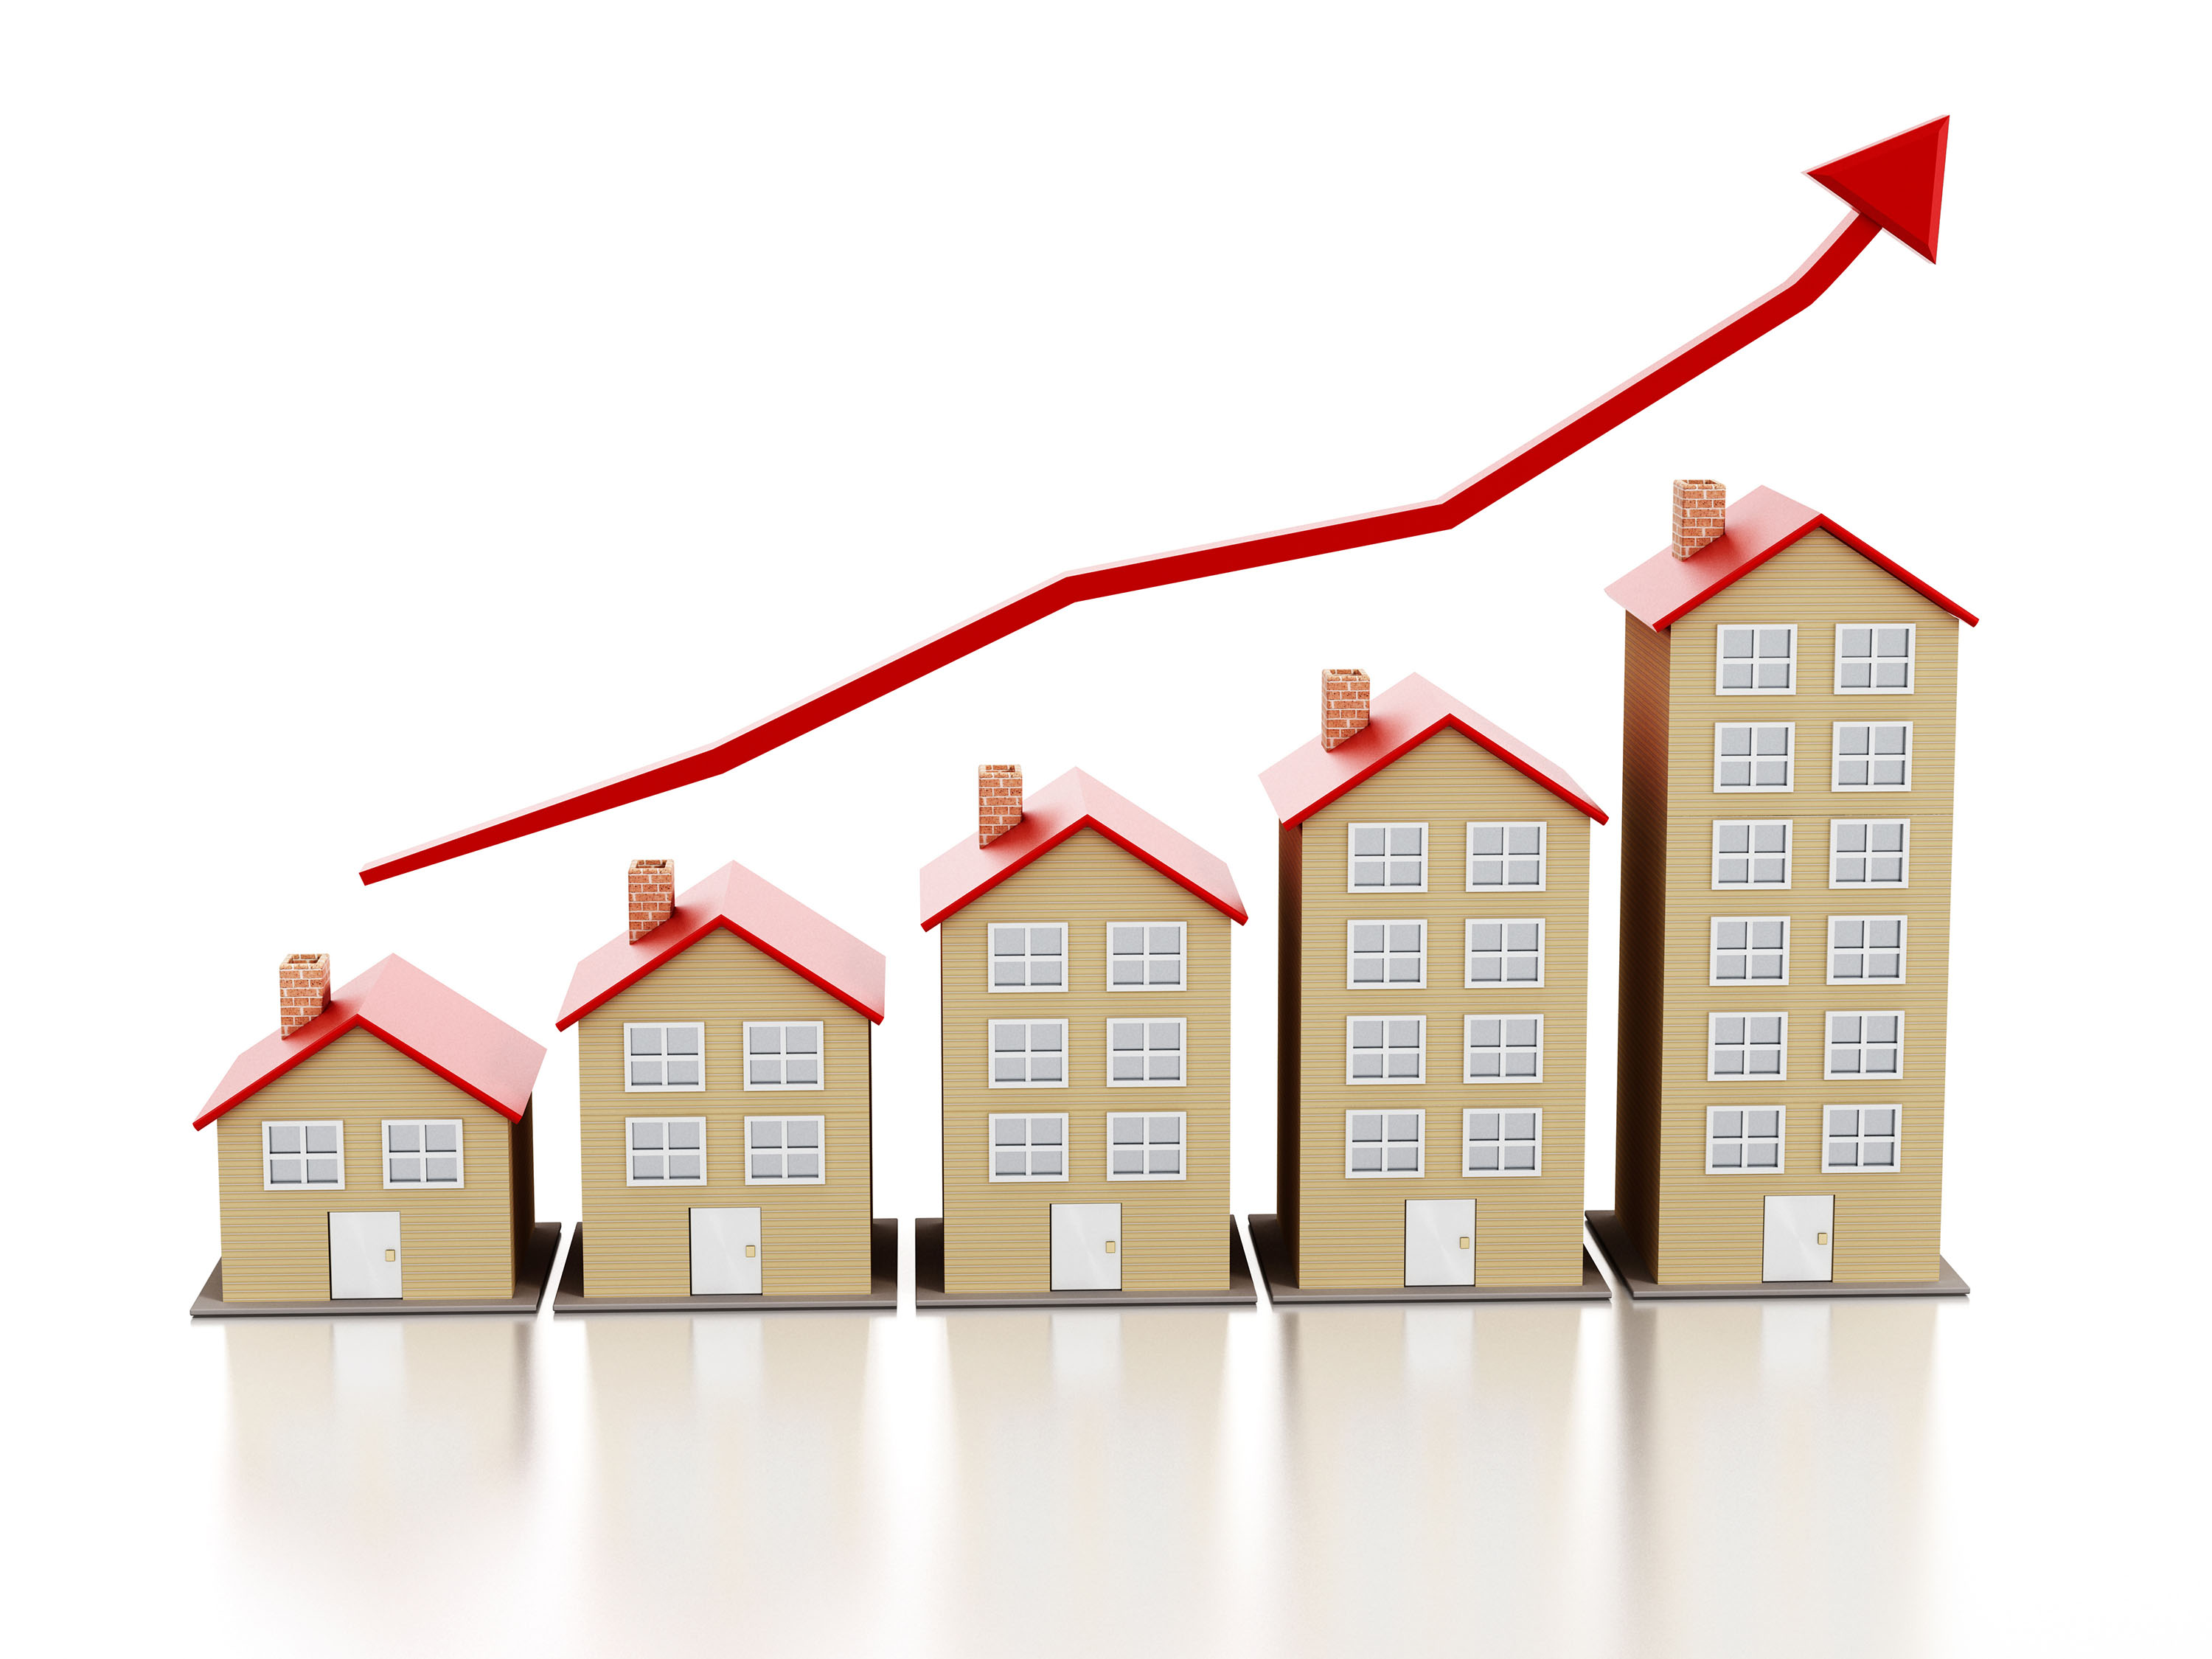

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


## *Table of Contents*
* [1. Introduction](#1)
* [2. Importing the Data](#2)  
* [3. Data Cleaning & Transformation](#3)
    * [3.1 Creating Dummy Codes](#3.1)
    * [3.2 Imputing or Deleting Missing Values](#3.2)
* [4. Train & Test the Model](#4)
-------------------------------------
<br>
<br>


## <a name="1"></a> 1. Introduction
-----------------------
House prices are constantly changing. These changes are driven by a plethora of factors which may seem like a daunting task to utilize for prediction. Fortunately, we have the option of applying a linear regression model to make sound predictions, as the independent variable (price) is a continuous variable. With a linear regression model we can add a large number of dependent variables to determine the price of a house. I believe it is possible to create a linear regression model based on a few but important dependent variables which could predict house prices within an acceptable range.   

#### Note on the Data
We will work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt). All our data is contained in a single `tsv` file.

### Objective:
* Develop a linear regression model to predict house prices
* Select the most essential dependent variables / features for the linear regression model by brute force. By brute force, I mean to look at each and every feature, and only select the features with the most predictive influence on the model.

<br>

## <a name="2"></a> 2. Importing the Data
-----------------------
Let's fire up the data by reading the `tsv` file and dive into the fun.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
%matplotlib inline

raw_data = pd.read_csv('Data/houses/AmesHousing.tsv', '\t')
raw_data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [2]:
raw_data.shape

(2930, 82)

We now know that we have data on ***2930*** house sales, with a range of ***82*** variables / features. This leaves us with quite some possibilities for assembling a linear regression model.

<br>

## <a name="3"></a> 3. Data Cleaning & Transformation
-----------------------
There are most kinds of data types in the dataset. Unfortunately, the linear regression model requires `quantitative` features such as `discrete` and `continuous` variables. Hence, we will need to ensure the data is prepared for the linear regression to process it.

We will start off by looking at the `date` variables. Dates alone does not provide much value to a linear regression model. On the other hand, the time between 2 dates can potentially contribute significantly.

The range between 2 dates which might hold some promise, could be the following:
* ***Number of years*** from the house was built to the garage was built
* ***Number of years*** from the house was built to the house was remodeled

Let's extract this information and drop the associated `date` variables and any variables that is associated with the sale of the house (except the sale price).

In [3]:
raw_data['years_until_garage'] = raw_data['Garage Yr Blt'] - raw_data['Year Built']
raw_data['years_until_remod'] = raw_data['Year Remod/Add'] - raw_data['Year Built']
raw_data.drop(columns = ['Garage Yr Blt', 'Year Remod/Add', 'Year Built', 'Mo Sold', 'Yr Sold', 'Sale Type', 'Sale Condition'], inplace=True )
raw_data[['years_until_garage', 'years_until_remod']].describe()

,years_until_garage,years_until_remod
count,2771.000000,2930.000000
mean,5.204980,12.910239
std,16.229887,24.032451
min,-20.000000,-1.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,18.000000
max,201.000000,127.000000


The `years_until_garage` and `years_until_remod` have now both been added to our dataframe. However, a glance at some descriptive statistics suggests that there have been some ***data entry errors*** in the original dataset. More specifically, some values are ***below 0*** which indicates that a garage was built or the house remodeled before the house was initially built - which is impossible.

While we will never know the true value of these cases, we can nevertheless perform an adjustment by changing the values to `0` which will reduce the error. 

In [4]:
raw_data.loc[raw_data['years_until_garage'] < 0,'years_until_garage'] = 0
raw_data.loc[raw_data['years_until_remod'] < 0,'years_until_remod'] = 0
raw_data[['years_until_garage', 'years_until_remod']].describe()

,years_until_garage,years_until_remod
count,2771.000000,2930.00000
mean,5.243594,12.91058
std,16.203139,24.03226
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,0.000000,18.00000
max,201.000000,127.00000


The descriptive statistics in the output 4 confirms the cases below 0 years have been corrected. It is worth noting from the output that most houses have never built a garage after the construction of the house, which might not be surprising.

<br>

### <a name="3.1"></a> 3.1 Creating Dummy Codes
As I previously mentioned, a linear regression model requires `discrete` and `continuous` variables. Therefore any `nominal` or `categorical ordinal` variables must be transformed into ***dummy variables***.

Let's take a look at the existing `nominal` or `categorical ordinal` variables.

In [5]:
data = raw_data.copy()
data.select_dtypes(include='object').head()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature
0,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Typ,Gd,Attchd,Fin,TA,TA,P,NaN,NaN,NaN
1,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,...,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN
2,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Typ,NaN,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2
3,RL,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN
4,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Typ,TA,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN


Approximately half of the variables in the dataframe are `nominal` or `categorical ordinal`. Since the process of transforming these variables into dummy variables will produce a new column (with `0` or `1`) for each unique category in a `qualitative` variable. Hence, we must limit ourselves to only include `qualitative` variables with less than ***5 unique categories***. Otherwise we risk getting an excess amount of features in our linear regression model, which will result in too high a ***prediction error variance***.

Fortunately, we can use the `pandas` library dummy coding option `get_dummies()` to make this process easier. When we have created the dummy variables, we will subsequently delete the original `qualitative` variable. 

In [6]:
dummy_columns = data.select_dtypes(include='object').columns
for col in dummy_columns:
    if len(data[col].unique()) < 5:
        col_dummies = pd.get_dummies(data[col], prefix=col, dtype=int)
        data = pd.concat([data, col_dummies], axis=1)
        del data[col]
    else:
        del data[col]
    
data.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Exter Qual_Gd,Exter Qual_TA,Central Air_N,Central Air_Y,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,1,526301100,20,141.0,31770,6,5,112.0,639.0,0.0,...,0,1,0,1,1,0,0,0,1,0
1,2,526350040,20,80.0,11622,5,6,0.0,468.0,144.0,...,0,1,0,1,0,0,1,0,0,1
2,3,526351010,20,81.0,14267,6,6,108.0,923.0,0.0,...,0,1,0,1,0,0,1,0,0,1
3,4,526353030,20,93.0,11160,7,5,0.0,1065.0,0.0,...,1,0,0,1,1,0,0,0,0,1
4,5,527105010,60,74.0,13830,5,5,0.0,791.0,0.0,...,0,1,0,1,1,0,0,0,0,1


In [7]:
data.dtypes.value_counts()

int32      30
int64      25
float64    11
dtype: int64

Output 7 confirms that all variables in the dataframe is now either an `int` or `float`.

<br>

### <a name="3.2"></a> 3.2 Imputing or Deleting Missing Values
The last thing we need to look at is the ***missing values***. In this project we will impute the `mean` of the variable if the amount of missing values is less than `5%` of the total amount of rows.

Let's locate the variables with less than `5%` missing values and impute the `mean`.

In [8]:
missing_data = data.isnull().sum()
low_miss = missing_data[(missing_data/data.shape[0] < 0.05) & (missing_data/data.shape[0] > 0)]
numeric_transform = data[low_miss.index.tolist()]
data[numeric_transform.columns] = numeric_transform.fillna(numeric_transform.mean())
data[numeric_transform.columns].isna().sum()

Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Cars       0
Garage Area       0
dtype: int64

`Output [8]` outlines the ***9 variables*** which were imputed with their own mean value. The only thing that remains is to remove any variables with 5% or more missing values from the dataframe. We will detect these variables first and subsequently remove them.

In [9]:
data.loc[:,data.isnull().any()].isna().sum()

Lot Frontage          490
years_until_garage    159
dtype: int64

In [10]:
data.dropna(axis=1, how='any', inplace=True)
data.shape

(2930, 64)

If we reflect on how we have created ***dummy variables*** and handled ***missing values***, it is acutally possible to create a `function` which will aid us in this project.

We can wrap this section up by creating a `function` which handles the dummy coding and missing values of this project. When this is done, we will create a ***clean dataframe*** by using this function.

In [11]:
def transform_features(data, max_categories):
    transform = data.copy()
        
    #Dummy Coding
    dummy_columns = transform.select_dtypes(include='object').columns
    for col in dummy_columns:
        if len(transform[col].unique()) < max_categories:
            col_dummies = pd.get_dummies(transform[col], prefix=col, dtype=int)
            transform = pd.concat([transform, col_dummies], axis=1)
            del transform[col]
        else:
            del transform[col]
    
    #Imputes the mean for numeric values with below 5% missing values
    missing_data = transform.isnull().sum()
    low_miss = missing_data[(missing_data/transform.shape[0] < 0.05) & (missing_data/transform.shape[0] > 0)]
    numeric_transform = transform[low_miss.index.tolist()]
    transform[numeric_transform.columns] = numeric_transform.fillna(numeric_transform.mean())
    
    transform.dropna(axis=1, how='any', inplace=True)
    
    return transform.copy()

In [12]:
clean_data = transform_features(raw_data, 5)
clean_data.shape

(2930, 64)

The `shape` method confirms that we have a final dataframe which is identical in size to the `data` dataframe from `output 10`. Let's continue to use the new `clean_data` dataframe for the remainder of this project.

<br>

## <a name="4"></a> 4. Single Feature Selection
-----------------------
Now that the data is assumptiously clean, we can proceed to create a linear regression model. We will follow the standard procedure of developing this linear regression model:
1. Dividing the data into both a ***training*** and ***testing*** partition.
2. ***Fit*** the model to the training partition using selected features.
3. ***Evaluate*** the model performance on the testing partition.

We will have to iterate this process many times in order to locate the most prominent variables / features for our model. The target feature is the `SalesPrice`, but we do not yet know which of the remaining features in the dataframe that could increase the precision and accuracy of the linear regression model.

In order to elude the most prominent features for house sales price prediction, we ***iterate through each variable*** in the dataframe by creating a linear regression model with only the one variable as the selected feature and calculate the `root mean squared error (RMSE)` of the model. In this way, we can get an overview of which variables provides some predictive potential to a linear regression model.

We will create a `function` to assist us with this step. Thereby, reduce the amount of code that is nessary to carry out this task. The `function` should take ***3 parameters*** - number of cross-validation partitions, dataframe and list of selected features. The `function` will fit a linear regression model, evaluate the model and provide the `mean RMSE` and `std RMSE`. 

In [13]:
def train_and_test(k_folds, dataframe, selected_features):
    kf = KFold(k_folds, shuffle=True, random_state=1)
    linear_model = LinearRegression()
    data = dataframe.copy()
    mses = cross_val_score(linear_model, data[selected_features], data['SalePrice'], scoring='neg_mean_squared_error', cv=kf)
    avg_rmse = np.mean(np.sqrt(np.abs(mses)))
    std_rmse = np.std(np.sqrt(np.abs(mses)))
    return [avg_rmse, std_rmse]   

The `train_and_test` function is now ready to be utilized. The next step is to iterate through each variable in the dataframe and calculate the `RMSE`.

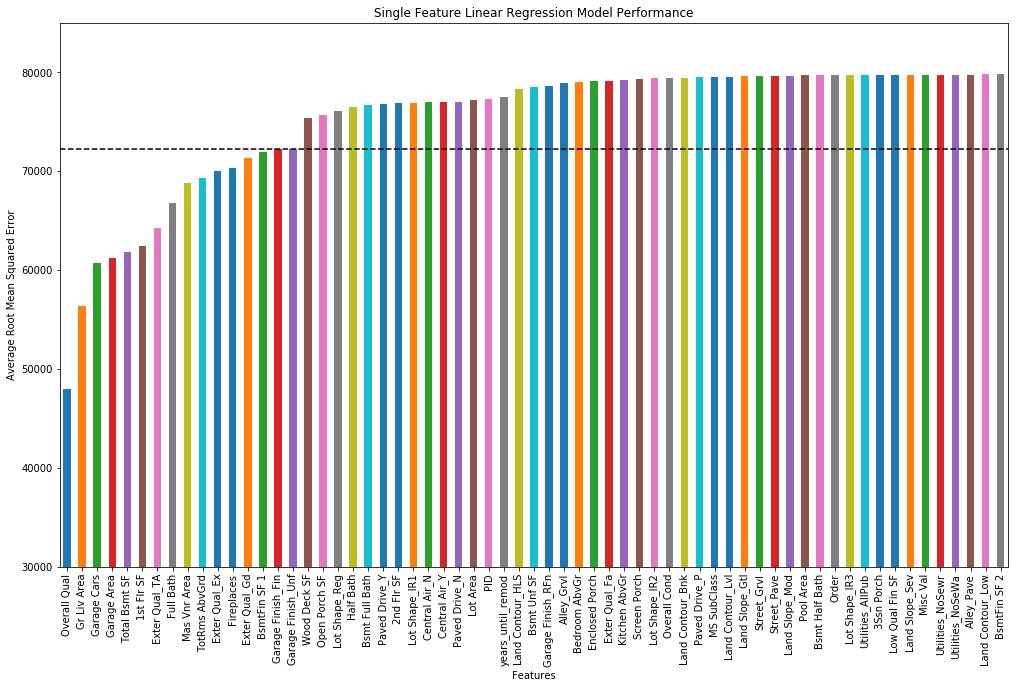

In [14]:
features = clean_data.drop(columns = ['SalePrice']).columns.tolist()
metrics = pd.DataFrame({'Feature': [], 'RMSE': []})
for feature in features:
    metrics = metrics.append({'Feature': feature, 'RMSE': train_and_test(10, clean_data, [feature])[0]}, ignore_index=True)
    
metrics.sort_values(by=['RMSE'], inplace=True)
metrics.plot.bar(x='Feature', y='RMSE', figsize=(17,10), title='Single Feature Linear Regression Model Performance', legend=False)
plt.ylim(30000,85000)
plt.ylabel('Average Root Mean Squared Error')
plt.xlabel('Features')
plt.axhline(72283.056548, color='black', linestyle='--')

The bar plot from `Output [14]` provides some really interesting information. From a relative point of view, ***the first 16 variables / features (from the left)*** seems to stand out from the remaining variables. I have added the black dash-line to highlight this fact. A closer inspection reveals that the `Overall Qual` indicates to be the most significant predcitor of the bunch - closely followed by `Gr Liv Area`. 

Let's continue to work with these 16 features and exclude the rest. 

In [15]:
metrics.iloc[0:16]

,Feature,RMSE
4,Overall Qual,47930.235300
14,Gr Liv Area,56337.726830
23,Garage Cars,60712.938595
24,Garage Area,61195.074760
10,Total Bsmt SF,61823.112358
11,1st Flr SF,62456.977294
54,Exter Qual_TA,64286.346907
17,Full Bath,66762.231967
6,Mas Vnr Area,68795.392058
21,TotRms AbvGrd,69273.762009


`Output 15` gives an excellent overview of the 16 features and their respective `RMSE`. In order to better grasp what each feature represents, I will provide a minor description from the [data-reference](https://s3.amazonaws.com/dq-content/307/data_description.txt):
1. `Overall Qual` - lala
2. `Gr Liv Area` - lulu

Before moving on, let's investigate the correlation with the `SalesPrice` for each feature.

In [16]:
corr_coeffs = clean_data.corr()['SalePrice'].abs().sort_values(ascending=False)
strong_corrs = corr_coeffs[corr_coeffs > 0.4]
strong_corrs = strong_corrs.to_frame()
strong_corrs['Feature'] = strong_corrs.index.tolist()
strong_corrs.rename(columns={'SalePrice': 'Corr'}, inplace=True)
metrics = pd.merge(metrics[0:16], strong_corrs, on='Feature', how='left')
metrics

,Feature,RMSE,Corr
0,Overall Qual,47930.235300,0.799262
1,Gr Liv Area,56337.726830,0.706780
2,Garage Cars,60712.938595,0.647861
3,Garage Area,61195.074760,0.640385
4,Total Bsmt SF,61823.112358,0.632105
5,1st Flr SF,62456.977294,0.621676
6,Exter Qual_TA,64286.346907,0.590897
7,Full Bath,66762.231967,0.545604
8,Mas Vnr Area,68795.392058,0.505784
9,TotRms AbvGrd,69273.762009,0.495474


Not surprisingly, both the correlation coeficient and the `RMSE` are closely correlated. This leads us to the next step.

<br>

### <a name="4.1"></a> 4.1 Feature Exclusion Due to Collinearity
Now that we have 16 features which could be included in a linear regression model, we first have to ensure that no ***collinearity*** exists between these features. In other words, if 1 or more features have a high correlation to each other, they will ***severely reduce the predictabiltiy*** they have on the linear regression model. Thus, we have to detect these cases and exclude the feature with the least `RMSE`.

Let's do this by calculating the correlation by which each variable have to every other variable in the dataframe. Subsequently, we can generate a ***heatmap*** to get a quick overview of the correlations.

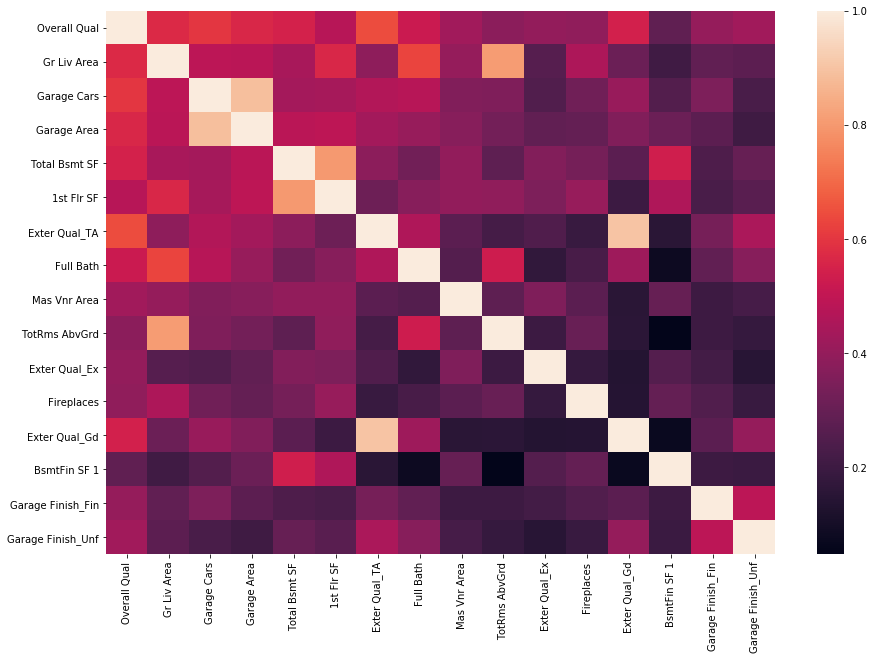

In [17]:
import seaborn as sns

strong_corrs = corr_coeffs[corr_coeffs > 0.4]
corrmat = clean_data.loc[:,metrics['Feature']]
corrmat = corrmat.corr().abs()
corrmat
plt.figure(figsize=(15, 10))
sns.heatmap(corrmat)

A quick glance at the ***heatmap*** reveals that most of the correlations are below `0.6`. However, a few features share a strong correlation. Let's isolate these strong correlations and create another heatmap.

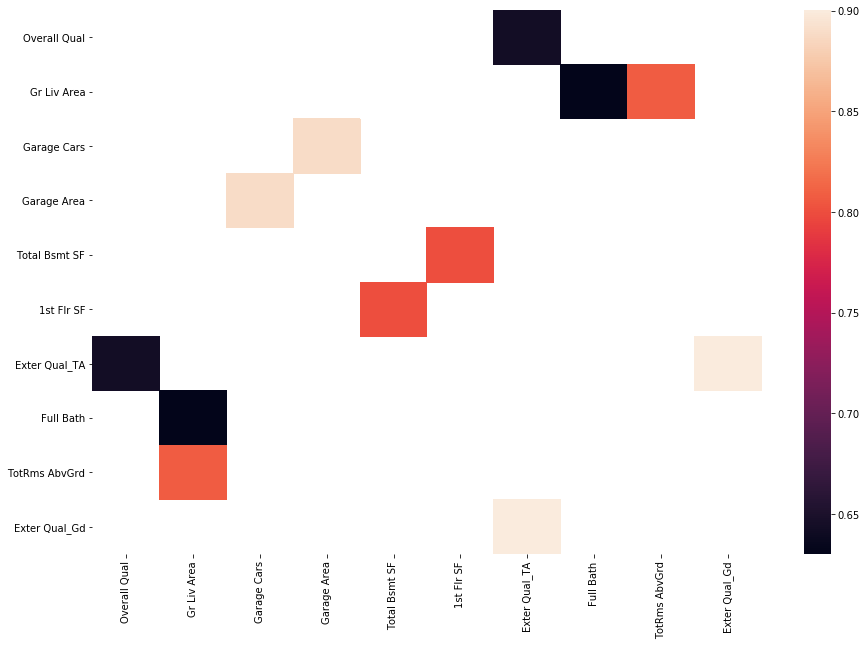

In [18]:
collinearity = corrmat[(corrmat >= 0.6) & (corrmat != 1)].dropna(axis=1, how='all')
collinearity = collinearity.dropna(axis=0, how='all')
plt.figure(figsize=(15, 10))
sns.heatmap(collinearity)

The new heatmap shows us that there are 6 strong correlations among 10 features. Some of these correlations seems very intuative such as `Garage Area` and `Garage Cars`. We will need to remove the features which provides the lesser predictability to the linear regression model.

In [19]:
coll_columns = collinearity.columns.tolist()
excluded_columns = list()
for column in coll_columns:
    exclude = collinearity[pd.notnull(collinearity[column])].index
    for x in exclude:
        excluded_columns.append(x)
        metrics = metrics[metrics['Feature'] != x]
        if x in coll_columns:
            coll_columns.remove(x)
        

excluded_columns

['Exter Qual_TA',
 'Full Bath',
 'TotRms AbvGrd',
 'Garage Area',
 '1st Flr SF',
 'Exter Qual_TA']

In [20]:
metrics

,Feature,RMSE,Corr
0,Overall Qual,47930.235300,0.799262
1,Gr Liv Area,56337.726830,0.706780
2,Garage Cars,60712.938595,0.647861
4,Total Bsmt SF,61823.112358,0.632105
8,Mas Vnr Area,68795.392058,0.505784
10,Exter Qual_Ex,70030.853989,0.480477
11,Fireplaces,70290.048057,0.474558
12,Exter Qual_Gd,71304.204388,0.446489
13,BsmtFin SF 1,71937.748116,0.432794
14,Garage Finish_Fin,72263.175021,0.424902


`Output [19]` confirms which columns have been removed and `Output [20]` gives us an overview of the remaining features at our disposal.

<br>

## <a name="5"></a> 5. Multi-Feature Selection
-----------------------
The next step is to ***find the most optimal combination of features*** for our linear regression model. We will do this simply by combining the 2 most infuencial features (lowest `RMSE`) and evaluate the model performance. Subsequently, we will iteratively add the next most influencial feature to the combination and evaluate the model performance for each new combination.

Let's create an entirely new dataframe with this information.

In [21]:
features = metrics['Feature'].tolist()
multi_feature_metrics = pd.DataFrame({'Features': [], 'RMSE': [], 'STD_RMSE': []})
for x in range(len(features)):
    model_metric = train_and_test(10, clean_data, features[0:x+2])
    multi_feature_metrics = multi_feature_metrics.append({'Features': features[0:x+2], 'RMSE': model_metric[0], 'STD_RMSE': model_metric[1]}, ignore_index=True)
    
multi_feature_metrics.sort_values(by=['RMSE'], inplace=True)
multi_feature_metrics['feature_nr'] = multi_feature_metrics.index + 2
multi_feature_metrics = multi_feature_metrics[multi_feature_metrics['feature_nr'] != 12]
multi_feature_metrics

,Features,RMSE,STD_RMSE,feature_nr
9,"[Overall Qual, Gr Liv Area, Garage Cars, Total...",33251.212055,7055.741161,11
8,"[Overall Qual, Gr Liv Area, Garage Cars, Total...",33344.623300,7104.622177,10
7,"[Overall Qual, Gr Liv Area, Garage Cars, Total...",33504.273219,7080.263160,9
6,"[Overall Qual, Gr Liv Area, Garage Cars, Total...",34505.522537,6274.578622,8
5,"[Overall Qual, Gr Liv Area, Garage Cars, Total...",35186.611951,6161.927972,7
4,"[Overall Qual, Gr Liv Area, Garage Cars, Total...",35499.622435,6242.321390,6
3,"[Overall Qual, Gr Liv Area, Garage Cars, Total...",36854.292685,5718.113135,5
2,"[Overall Qual, Gr Liv Area, Garage Cars, Total...",37367.609650,5438.287735,4
1,"[Overall Qual, Gr Liv Area, Garage Cars]",39524.660039,4059.075979,3
0,"[Overall Qual, Gr Liv Area]",41231.285091,3785.333715,2


`Output [21]` outlines the 11 different combinations with their respective `RMSE` and `STD_RMSE`. In order to get a better overview, will plot these multi-feature combinations in a bar plot.

Text(0.5, 0, 'Number of Features')

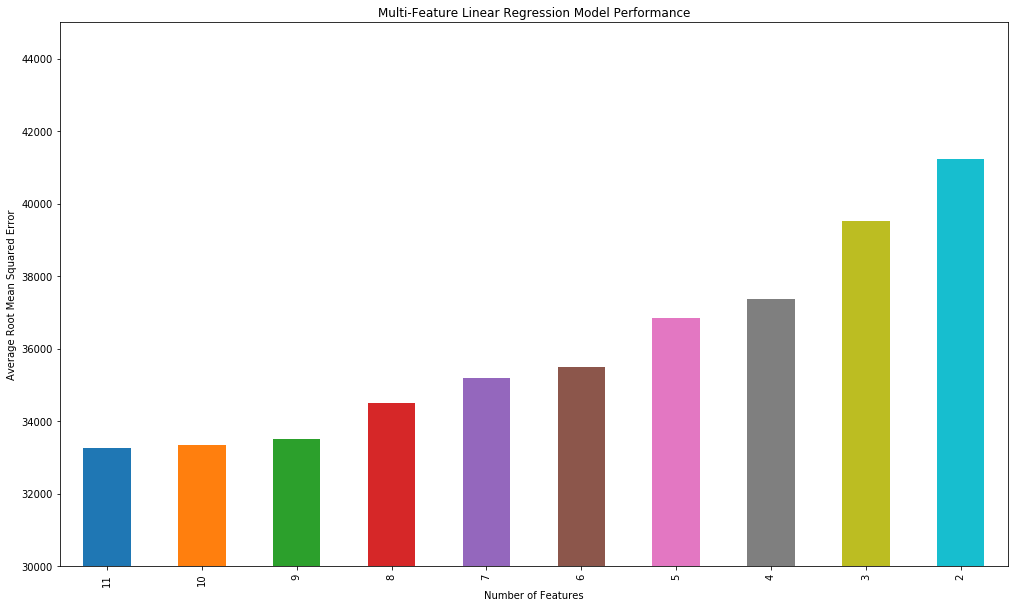

In [22]:
multi_feature_metrics.sort_values(by=['RMSE'], inplace=True)
multi_feature_metrics.plot.bar(x='feature_nr', y='RMSE', figsize=(17,10), title='Multi-Feature Linear Regression Model Performance', legend=False)
plt.ylim(30000,45000)
plt.ylabel('Average Root Mean Squared Error')
plt.xlabel('Number of Features')

The bar plot clearly shows a trend. For each extra feature we place in the linear regression model the `RMSE` decreases. It may be tempting to include all 11 features in the model, however ***it is not that simple***. We have to consider another factor - namely the increasing variance that is associated with increasing number of features.

Let's create a classic bias-variance cutoff plot, using both the `RMSE` and `STD_RMSE` (standard deviation of RMSE).

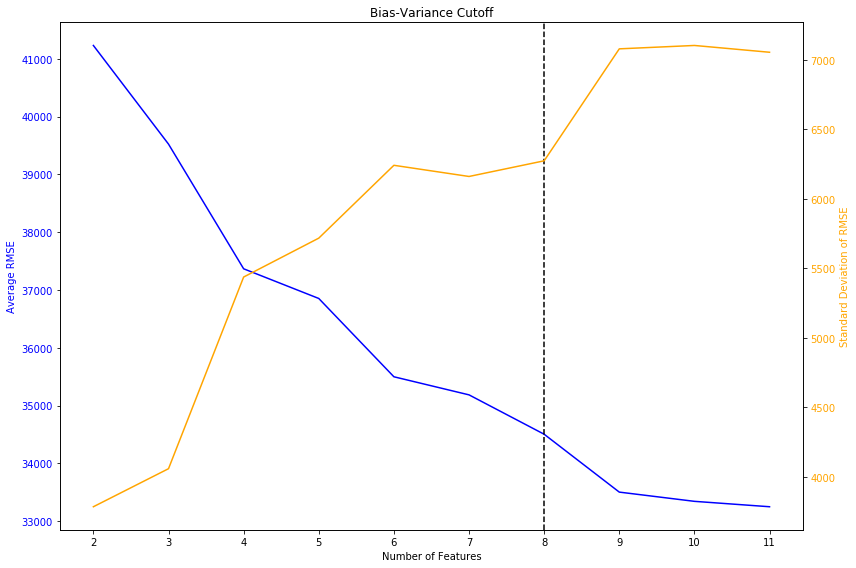

In [23]:
plt.style.use('tableau-colorblind10')
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(multi_feature_metrics['feature_nr'], multi_feature_metrics['RMSE'], color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Average RMSE', color='blue')
plt.xticks(np.arange(1, 13, step=1))
plt.title('Bias-Variance Cutoff')
plt.axvline(8, color='black', linestyle='--')
ax2 = ax1.twinx()
ax2.plot(multi_feature_metrics['feature_nr'], multi_feature_metrics['STD_RMSE'], color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylabel('Standard Deviation of RMSE', color='orange')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

This ***bias-variance plot*** clearly demonstrates the fundamental issue of selecting features for a linear regression model. First and foremost, the average `RMSE` decreases as we include more features to the model (just as we observed in the bar plot). ***But there is a catch*** - as we increase the number of features in a linear regression model, the `RMSE` variance increases (using standard deviation in this case). The dilemma is to select the number of features based on what degree of variance that will be acceptable.

In our case with predicting hosue prices, ***a higher variance will be acceptable*** (it is not for predicting medical diagnosis). Therefore, we will select the model with `8` features (dashed reference line). Using a linear regression model with these `8` features to predict house prices will result in an average error rate of `34.500 USD` from the true value. When also considering the standard deviation, it will not be unrealistic to get a ***prediciton error*** ranging from `21.500 USD` to `47.500 USD`.

Now that we have finally chosen the features for the model, we can take a closer look on the the ***linear regression equation***. We can extract this information by using sklearn library. 

In [24]:
def train_and_predict(dataframe, selected_features):
    linear_model = LinearRegression()
    data = dataframe.copy()
    linear_model.fit(data[selected_features], data['SalePrice'])
    predictions = linear_model.predict(data[selected_features])
    return [predictions, linear_model.coef_]

final_features = multi_feature_metrics.loc[multi_feature_metrics['feature_nr'] == 8, 'Features'].tolist()
print(train_and_predict(clean_data, final_features[0])[1])

[1.64829573e+04 4.14115055e+01 1.46082769e+04 2.62489308e+01
 2.77938604e+01 8.00789344e+04 9.94116161e+03 1.94680973e+04]


In [25]:
from sklearn.utils import shuffle

linear_model = LinearRegression()
data = clean_data.copy()
data = shuffle(data)
data.reset_index(inplace=True)
train_data = data.loc[data.index[0:1465]]
test_data = data.loc[data.index[1465:]]
linear_model.fit(train_data[final_features[0]], train_data['SalePrice'])
predictions = linear_model.predict(test_data[final_features[0]])
test_data['predictions'] = predictions
test_data[['SalePrice','predictions']].to_csv('Data/houses/house_predictions.csv')

In [26]:
%%HTML
<div class='tableauPlaceholder' id='viz1544350764096' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;PredictionsofHousePrices&#47;Sheet2&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='PredictionsofHousePrices&#47;Sheet2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;PredictionsofHousePrices&#47;Sheet2&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1544350764096');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>